### This notebook is used to train unimodal LSTM autoencoders and save the encoded representation. It also computes the FV from the encoded representation, performs feature selection and Random Forest Classification.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import os
import cv2
import os
import json
import itertools as it
import keras
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Masking
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.utils import plot_model
from keras import optimizers
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GMM

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Read data for training unimodal models

In [2]:
modalities = ["visual", "audio", "audioE"]
visual_modalities = ["facial", "gaze", "pose", "action"]
modality = modalities[1]
visual_modality = visual_modalities[0]

print ("Loading %s modality" %modality)

if (modality == "visual"):
    
    if (visual_modality=="facial"):
        X_train = np.load("../TemporalData60/train_landmarks.npy")
        X_dev = np.load("../TemporalData60/dev_landmarks.npy")
        
    elif (visual_modality=="gaze"):
        X_train = np.load("../TemporalData60/train_gaze.npy")
        X_dev = np.load("../TemporalData60/dev_gaze.npy")
        
    elif (visual_modality=="pose"):
        X_train = np.load("../TemporalData60/train_pose.npy")
        X_dev = np.load("../TemporalData60/dev_pose.npy")
        
    else:
        X_train = np.load("../TemporalData60/train_action.npy")
        X_dev = np.load("../TemporalData60/dev_action.npy")
            
    
    print ("Autoencoder visual train data has this shape", X_train.shape)
    print ("Autoencoder visual dev data has this shape", X_dev.shape)
    
elif (modality == "audio"):
    
    X_train = np.load("../TemporalData60/train_audio.npy")
    X_dev = np.load("../TemporalData60/dev_audio.npy")
    
    print ("Autoencoder audio train data has this shape", X_train.shape)
    print ("Autoencoder audio dev data has this shape", X_dev.shape)
    
else:
    
    X_train = np.load("../TemporalData60/train_audioE.npy")
    X_dev = np.load("../TemporalData60/dev_audioE.npy")
    
    print ("Autoencoder audioE train data has this shape", X_train.shape)
    print ("Autoencoder audioE dev data has this shape", X_dev.shape)


Loading audio modality
Autoencoder audio train data has this shape (753231, 60, 117)
Autoencoder audio dev data has this shape (313444, 60, 117)


In [3]:
#put data together for the autoencoder training
X = np.vstack((X_train, X_dev))
del X_train
del X_dev
print (X.shape)

(1066675, 60, 117)


### Define the model

In [4]:
#MODEL DEFINITION
hidden_ratio = 0.3
timesteps, n_features = X.shape[1] , X.shape[2]
dimensions_lstm = round(n_features*hidden_ratio)
print ('Hidden dimension %i' %dimensions_lstm)
# encoder part
# input placeholder
input_data = Input(shape=(timesteps, n_features))
encoded = Bidirectional(LSTM(dimensions_lstm, activation='relu', return_sequences=False))(input_data)
#connection between encoder and decoder
middle_representation = RepeatVector(timesteps)(encoded)
# decoder part
decoded = Bidirectional(LSTM(dimensions_lstm, activation='relu', return_sequences=True))(middle_representation)
decoded = TimeDistributed(Dense(n_features, activation = 'linear'))(decoded)
autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)
# for clipping gradients
#ADAM = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=0.5)
#autoencoder.compile(loss='mae', optimizer=ADAM)
autoencoder.compile(loss='mae', optimizer="adam")
print("--" * 20)
print("autoencoder")
print(autoencoder.summary())
print("--" * 20)
print("encoder")
print(encoder.summary())

Hidden dimension 35
Instructions for updating:
Colocations handled automatically by placer.
----------------------------------------
autoencoder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 117)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70)                42840     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 60, 70)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 70)            29680     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 117)           8307      
Total params: 80,827
Trainable params: 80,827
Non-trainable params: 0
___________________________________________________________

### Create directory and save weights

In [5]:
save_dir = '../FINAL_RESULTS_60'
feature_type = 'MFCC'

In [6]:
save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_dimensionsBiLstm'+str(dimensions_lstm)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    print("Directory " , save_dir ,  " Created ")
else:    
    print("Directory " , save_dir ,  " already exists")

Directory  ../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35  Created 


In [7]:
from keras.callbacks import EarlyStopping

csv_logger = CSVLogger(os.path.join(save_dir, "logger.csv"))
checkpoint = ModelCheckpoint(os.path.join(save_dir, "weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"), 
                             monitor='loss', 
                             verbose=1, save_best_only=True, mode='min')

callbacks_list = [csv_logger, checkpoint]

hist = autoencoder.fit(X, X, epochs=20,
                batch_size=5120,
                callbacks=callbacks_list, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1066675/1066675 [==============================] - 352s 330us/step - loss: 697.8773

Epoch 00001: loss improved from inf to 697.87732, saving model to ../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/weights-improvement-01-697.88.hdf5
Epoch 2/5
1066675/1066675 [==============================] - 338s 317us/step - loss: 687.3134

Epoch 00002: loss improved from 697.87732 to 687.31336, saving model to ../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/weights-improvement-02-687.31.hdf5
Epoch 3/5
1066675/1066675 [==============================] - 338s 317us/step - loss: 222.9379

Epoch 00003: loss improved from 687.31336 to 222.93786, saving model to ../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/weights-improvement-03-222.94.hdf5
Epoch 4/5
1066675/1066675 [==============================] - 338s 317us/step - loss: 220.9236

Epoch 00004: loss improved from 222.93786 to 220.92364, saving model to ../FINAL_RESULTS_

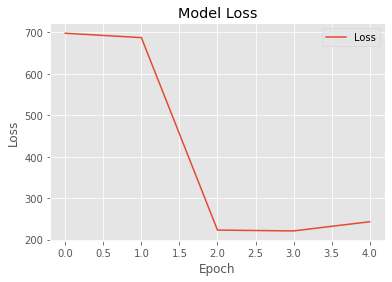

In [8]:
plt.style.use('ggplot')
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper right')
plt.savefig(os.path.join(save_dir, 'LOSS.png'))
plt.show()
autoencoder.save_weights(os.path.join(save_dir, 'BI_LSTM_DYNAMICS.h5'))
del X

### Model is trained -- Encod train and dev sets 

In [9]:
print ("Loading %s modality" %modality)

if (modality == "visual"):
    
    if (visual_modality=="facial"):
        X_train = np.load("../TemporalData60/train_landmarks.npy")
        X_dev = np.load("../TemporalData60/dev_landmarks.npy")
        
    elif (visual_modality=="gaze"):
        X_train = np.load("../TemporalData60/train_gaze.npy")
        X_dev = np.load("../TemporalData60/dev_gaze.npy")
        
    elif (visual_modality=="pose"):
        X_train = np.load("../TemporalData60/train_pose.npy")
        X_dev = np.load("../TemporalData60/dev_pose.npy")
        
    else:
        X_train = np.load("../TemporalData60/train_action.npy")
        X_dev = np.load("../TemporalData60/dev_action.npy")
            
    
    print ("Autoencoder visual train data has this shape", X_train.shape)
    print ("Autoencoder visual dev data has this shape", X_dev.shape)
    
elif (modality == "audio"):
    
    X_train = np.load("../TemporalData60/train_audio.npy")
    X_dev = np.load("../TemporalData60/dev_audio.npy")
    
    
    print ("Autoencoder audio train data has this shape", X_train.shape)
    print ("Autoencoder audio dev data has this shape", X_dev.shape)
    
else:
    
    X_train = np.load("../TemporalData60/train_audioE.npy")
    X_dev = np.load("../TemporalData60/dev_audioE.npy")
    
    print ("Autoencoder audioE train data has this shape", X_train.shape)
    print ("Autoencoder audioE dev data has this shape", X_dev.shape)
    

Loading audio modality
Autoencoder audio train data has this shape (753231, 60, 117)
Autoencoder audio dev data has this shape (313444, 60, 117)


In [10]:
print ('Encoding representation')
encoded_train = encoder.predict(X_train)
print ('Encoding train done')
encoded_dev = encoder.predict(X_dev)
print ('Encoding done!')

Encoding representation
Encoding train done
Encoding done!


In [11]:
encoded_dir = '../FINAL_RESULTS_60'
encoded_dir = encoded_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_dimensionsBiLstm'+str(dimensions_lstm)+'/encoding'
if not os.path.exists(encoded_dir):
    os.mkdir(encoded_dir)
    print("Directory " , encoded_dir ,  " Created ")
else:    
    print("Directory " , encoded_dir ,  " already exists")
    
np.save(os.path.join(encoded_dir, 'encoded_train'), encoded_train)
np.save(os.path.join(encoded_dir, 'encoded_dev'), encoded_dev)
del X_train
del X_dev

Directory  ../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/encoding  Created 


In [12]:
def frame2session(encoded_dir, x_train_length, x_dev_length):
    tmp = list()
    tmp2 = list()
    X_train_frame = np.load(encoded_dir + "/encoded_train.npy")
    indices = np.zeros((len(x_train_length)+1))
    indices[0] = 0
    for i in range(1, len(x_train_length)):
        indices[i] = indices[i-1] + x_train_length[i-1]
    indices[len(x_train_length)] = sum(x_train_length)-1 
    for i in range(len(indices)-1):
        tmp.append(X_train_frame[int(indices[i]):int(indices[i+1]),:])
        
    X_dev_frame = np.load(encoded_dir + "/encoded_dev.npy")
    indices2 = np.zeros((len(x_dev_length)+1))
    indices2[0] = 0
    for i in range(1, len(x_dev_length)):
        indices2[i] = indices2[i-1] + x_dev_length[i-1]
    indices2[len(x_dev_length)] = sum(x_dev_length)-1 
    for i in range(len(indices2)-1):
        tmp2.append(X_dev_frame[int(indices2[i]):int(indices2[i+1]),:])
        
    return tmp, tmp2

In [13]:
def fisher_vector(xx, gmm, normalized=True):
    """Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covars_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    fisher =  np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))
    if normalized:
            fisher = np.sqrt(np.abs(fisher)) * np.sign(fisher) # power normalization
            fisher = fisher / np.linalg.norm(fisher, axis=0) # L2 norm
            
    return fisher

In [14]:
x_train_length = np.load("../TemporalData60/train_length.npy")
x_dev_length = np.load("../TemporalData60/dev_length.npy")

y_train_session = np.load("../TemporalData60/session_label_train.npy")
y_dev_session = np.load("../TemporalData60/session_label_dev.npy")

X_frame_train, X_frame_dev = frame2session(encoded_dir, x_train_length, x_dev_length)
print (len(X_frame_train))
print (len(X_frame_dev))

104
60


In [15]:
import warnings
warnings.filterwarnings(action='once')

encoded_dir = '../FINAL_RESULTS_60'
encoded_dir = encoded_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_dimensionsBiLstm'+str(dimensions_lstm)+'/encoding'
if not os.path.exists(encoded_dir):
    os.mkdir(encoded_dir)
    print("Directory " , encoded_dir ,  " Created ")
else:    
    print("Directory " , encoded_dir ,  " already exists")
    
    
save_dir = '../FINAL_RESULTS_60'
save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_dimensionsBiLstm'+str(dimensions_lstm)+'/fisherVectors'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    print("Directory " , save_dir ,  " Created ")
else:    
    print("Directory " , save_dir ,  " already exists")
    
X_train_session, X_dev_session = frame2session(encoded_dir, x_train_length, x_dev_length)

    
kernels = [16 , 32]
for kernel in kernels:
    
    print ('Computing kernel %i' %kernel)
    fv_train, fv_dev = [], []

    for X_train in X_train_session:
        gmm = GMM(n_components=kernel, covariance_type='diag')
        gmm.fit(X_train)
        fv = fisher_vector(X_train, gmm)
        fv_train.append(fv)

    for X_dev in X_dev_session:
        gmm = GMM(n_components=kernel, covariance_type='diag')
        gmm.fit(X_dev)
        fv = fisher_vector(X_dev, gmm)
        fv_dev.append(fv)

    np.save(os.path.join(save_dir, 'fisher_vector_train_%i' %kernel), fv_train)
    np.save(os.path.join(save_dir, 'fisher_vector_dev_%i' %kernel), fv_dev)

    np.save(os.path.join(save_dir, 'session_label_train'), y_train_session)
    np.save(os.path.join(save_dir, 'session_label_dev'), y_dev_session)


Directory  ../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/encoding  already exists
Directory  ../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/fisherVectors  Created 
Computing kernel 16


/home/ceccarelli/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/ceccarelli/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/ceccarelli/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


Computing kernel 32


In [16]:
#feature selection
kernels = [16, 32]
feat_numbers = [50, 100]

for kernel in kernels:
    for feat_number in feat_numbers:
        save_dir = '../FINAL_RESULTS_60'
        save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_dimensionsBiLstm'+str(dimensions_lstm)+'/fisherVectors'

        X_train = np.load(os.path.join(save_dir, 'fisher_vector_train_%i.npy' %kernel))
        X_dev = np.load(os.path.join(save_dir, 'fisher_vector_dev_%i.npy' %kernel))
        y_train = np.load(os.path.join(save_dir, 'session_label_train.npy'))
        y_dev = np.load(os.path.join(save_dir, 'session_label_dev.npy'))

        print (X_train.shape)
        print (X_dev.shape)
        print (y_train.shape)
        print (y_dev.shape)

        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=800, criterion='entropy')
        df = pd.DataFrame(np.vstack((X_train, X_dev)))
        feature_names = ['feature_%d' % i for i in range(len(X_train[0]))]
        df.columns = feature_names
        y = np.hstack((y_train, y_dev))
        print(df.head())

        model.fit(df, y)
        importances = model.feature_importances_
        print("\nfeature importance ranking")
        indices = np.argsort(importances)[::-1]
        for f in range(feat_number):
            print("%d. feature %d %s (%f)" % (f+1, indices[f], feature_names[indices[f]], importances[indices[f]]))
        indices = indices[:feat_number]

        X_train_df = pd.DataFrame(X_train)
        X_train_df.columns = ['feature_%d' % i for i in range(len(X_train[0]))]
        X_train_tree = X_train_df.iloc[:, indices]

        X_dev_df = pd.DataFrame(X_dev)
        X_dev_df.columns = ['feature_%d' % i for i in range(len(X_dev[0]))]
        X_dev_tree = X_dev_df.iloc[:, indices]

        print(X_train_tree.shape, X_dev_tree.shape)

        save_dir = '../FINAL_RESULTS_60'
        save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_dimensionsBiLstm'+str(dimensions_lstm)

        np.save(os.path.join(save_dir, 'X_train_tree_%i_%i' %(kernel, feat_number)), X_train_tree)
        np.save(os.path.join(save_dir, 'X_dev_tree_%i_%i' %(kernel, feat_number)), X_dev_tree)

(104, 2256)
(60, 2256)
(104,)
(60,)
   feature_0     feature_1     feature_2     feature_3     feature_4  \
0  -0.000189 -1.240461e-09 -1.240461e-09 -1.240461e-09 -1.240461e-09   
1   0.000464 -2.906718e-04  4.016815e-04 -2.732629e-04  2.567710e-04   
2   0.000002 -1.294160e-12 -1.294160e-12 -1.283455e-06 -1.283455e-06   
3  -0.001671 -1.352141e-09 -1.352224e-09 -1.352224e-09 -1.352348e-09   
4   0.000322 -1.589314e-09  6.289694e-04  6.923613e-04  8.650825e-05   

      feature_5     feature_6     feature_7     feature_8     feature_9  ...  \
0 -1.240157e-09 -1.240461e-09 -8.050809e-04  2.020904e-03 -1.873505e-03  ...   
1  1.235931e-03  1.172229e-04  3.995294e-04 -3.916362e-04  1.271855e-04  ...   
2  2.563476e-06 -1.283455e-06 -1.283455e-06 -1.283455e-06 -1.294160e-12  ...   
3  3.705039e-08 -1.352348e-09 -1.352348e-09 -1.364961e-09  1.670584e-03  ...   
4  3.271429e-04 -5.832298e-04  1.036471e-04 -7.497531e-04  1.245722e-03  ...   

   feature_2246  feature_2247  feature_2248  featu

      feature_0     feature_1     feature_2     feature_3     feature_4  \
0 -2.763211e-05 -1.479029e-09 -1.479029e-09 -1.479029e-09 -1.479029e-09   
1 -1.027932e-03  1.454592e-04 -1.003147e-04  2.046178e-04  3.832301e-05   
2 -8.431040e-07 -1.217126e-12 -1.217126e-12 -1.206173e-06 -1.206173e-06   
3 -1.014059e-06 -7.238331e-06 -1.183598e-11 -1.183273e-11 -1.183128e-11   
4  2.981465e-04 -2.129531e-09 -2.652456e-04 -4.007589e-04  6.296440e-04   

      feature_5     feature_6     feature_7     feature_8     feature_9  ...  \
0 -1.479029e-09  1.700249e-04  2.905906e-05 -1.479029e-09 -1.479029e-09  ...   
1  1.114341e-03  4.279902e-05 -7.483097e-04 -7.255926e-04 -2.062755e-03  ...   
2 -1.206173e-06  1.705756e-06 -4.323578e-07 -1.217126e-12 -1.206173e-06  ...   
3 -1.183598e-11 -1.183598e-11 -1.183598e-11 -1.183273e-11 -1.183598e-11  ...   
4 -6.799397e-04 -3.161238e-04  1.417949e-03 -1.827192e-04  6.630353e-04  ...   

   feature_4502  feature_4503  feature_4504  feature_4505  feature_4

In [20]:
class RandomForestCV():
   
    def __init__(self, feature_name, X_train, y_train, X_dev, y_dev, line):
        self.config = json.load(open('../model.json', 'r'))
        self.model_name = 'RF_CV'
        self.feature_name = feature_name
        self.X_train = X_train
        self.X_dev = X_dev
        self.y_train = y_train
        self.y_dev = y_dev
        self.parameters = dict()
        self.parameters['n_estimators'] = None
        self.parameters['max_features'] = None
        self.parameters['max_depth'] = None
        self.parameters['criterion'] = None
        self.model = None
        self.line = line

    def run(self):
        """main function for the model"""
        filename = os.path.join(self.line, '%s_%s_params.json' % (self.model_name, self.feature_name))

        if os.path.isfile(filename):
            self.parameters = json.load(open(filename, 'r'))
        
        if not self.parameters['n_estimators'] or not self.parameters['max_features'] or not self.parameters['max_depth'] or not self.parameters['criterion']:
            print("\nhyperparameters are not tuned yet")
            self.crossvalidate()
        else:
            self.model = RandomForestClassifier(
                n_estimators=self.parameters['n_estimators'], 
                max_features=self.parameters['max_features'], 
                max_depth=self.parameters['max_depth'], 
                criterion=self.parameters['criterion'], 
                verbose=1, n_jobs=-1,
                class_weight="balanced")
            self.model.fit(self.X_train, self.y_train)
            y_pred_train = self.model.predict(self.X_train)
            y_pred_dev = self.model.predict(self.X_dev)
            
            precision, recall, fscore, _ = precision_recall_fscore_support(self.y_dev, y_pred_dev, average='macro')

            print("\naccuracy on training set: %.4f" % metrics.accuracy_score(y_pred_train, self.y_train))
            print("\naccuracy on development set: %.4f" % metrics.accuracy_score(y_pred_dev, self.y_dev))
            print("\nprecision on dev set: %.4f" % precision)
            print("\nrecall on dev set: %.4f" % recall)
            print("\nfscore on dev set: %.4f" % fscore)
        
            
    def crossvalidate(self):
        
        parameters = {
            "n_estimators": self.config['baseline']['random_forest']['n_estimators'],
            "max_features": self.config['baseline']['random_forest']['max_features'],
            "max_depth": self.config['baseline']['random_forest']['max_depth'],
            "criterion": ["entropy"]
        }
        
        print("\nrunning the Grid Search for Random Forest CV classifier ...")
        clf = GridSearchCV(RandomForestClassifier(), 
                        parameters, 
                        cv=5, 
                        n_jobs=-1, 
                        verbose=3, 
                        scoring='recall_macro')
        
        clf.fit(self.X_train, self.y_train)
        print("\nfinal score for the tuned model\n", clf.score(self.X_dev, self.y_dev))
        print("\nbest hyperparameters for the tuned model\n", clf.best_params_)
        print("\ncross validation results (MEAN)\n", clf.cv_results_['mean_test_score'])
        print("\ncross validation results (STD)\n", clf.cv_results_['std_test_score'])

        self.parameters['n_estimators'] = clf.best_params_['n_estimators']
        self.parameters['max_features'] = clf.best_params_['max_features']
        self.parameters['max_depth'] = clf.best_params_['max_depth']
        self.parameters['criterion'] = clf.best_params_['criterion']
        
        filename = os.path.join(self.line, '%s_%s_params.json' % (self.model_name, self.feature_name))
        
        # write to model json file
        with open(filename, 'w') as output:
            json.dump(self.parameters, output)
            output.write("\n")
        output.close()
        
        best_grid = clf.best_estimator_
        print("\nevaluating the Random Forest Classifier ...")
        y_pred_train = best_grid.predict(self.X_train)
        y_pred_dev = best_grid.predict(self.X_dev)
        
        precision, recall, fscore, _ = precision_recall_fscore_support(self.y_dev, y_pred_dev, average='macro')
        
        filename = os.path.join(self.line, '%s_%s_score.json' % (self.model_name, self.feature_name))
        file = open(filename,"w") 
        file.write("\nprecision on dev set: %.4f" % precision) 
        file.write("\nrecall on dev set: %.4f" % recall) 
        file.write("\nfscore on dev set: %.4f" % fscore) 
        file.write("\naccuracy on dev set: %.4f" % metrics.accuracy_score(y_pred_dev, y_dev)) 
        file.close() 

        print("\naccuracy on training set: %.4f" % metrics.accuracy_score(y_pred_train, self.y_train))
        print("\naccuracy on development set: %.4f" % metrics.accuracy_score(y_pred_dev, self.y_dev))
        print("\nprecision on dev set: %.4f" % precision)
        print("\nrecall on dev set: %.4f" % recall)
        print("\nfscore on dev set: %.4f" % fscore)
        
        

    

In [22]:
print("\nrunning Random Forest with Cross Validation on Fisher Vectors")

kernels = [16, 32]
feat_numbers = [50, 100]
feature_type = 'MFCC'

for kernel in kernels:
    for feat_number in feat_numbers:
        print ('Kernels %i and features number %i' %(kernel, feat_number))

        save_dir = '../FINAL_RESULTS_60'
        save_dir = save_dir + '/'+feature_type+'_timesteps'+str(timesteps)+'_dimensionsBiLstm'+str(dimensions_lstm)

        X_train = np.load(os.path.join(save_dir, 'X_train_tree_%i_%i.npy' %(kernel, feat_number)))
        X_dev = np.load(os.path.join(save_dir, 'X_dev_tree_%i_%i.npy' %(kernel, feat_number)))

        label_path = '../FINAL_RESULTS_60'
        label_path = label_path + '/'+feature_type+'_timesteps'+str(timesteps)+'_dimensionsBiLstm'+str(dimensions_lstm)+'/fisherVectors/'
        y_train = np.load(os.path.join(label_path, 'session_label_train.npy'))
        y_dev = np.load(os.path.join(label_path, 'session_label_dev.npy'))

        print (X_train.shape)
        print (X_dev.shape)
        print (y_train.shape)
        print (y_dev.shape)
        
        feature_name = 'MFCC'
        feature_name = feature_name +'_'+str(kernel)+'_'+str(feat_number) 
        random_forest = RandomForestCV(feature_name, X_train, y_train, X_dev, y_dev, save_dir)
        random_forest.run()
        print ("------"  * 10)


running Random Forest with Cross Validation on Fisher Vectors
Kernels 16 and features number 50
(104, 50)
(60, 50)
(104,)
(60,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='../model.json' mode='r' encoding='UTF-8'>
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.TextIOWrapper name='../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/RF_CV_MFCC_16_50_params.json' mode='r' encoding='UTF-8'>
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=80)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=80)]: Done 200 out of 200 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='../model.json' mode='r' encoding='UTF-8'>
  a


accuracy on training set: 0.9231

accuracy on development set: 0.5167

precision on dev set: 0.5238

recall on dev set: 0.5238

fscore on dev set: 0.5238
------------------------------------------------------------
Kernels 16 and features number 100
(104, 100)
(60, 100)
(104,)
(60,)


[Parallel(n_jobs=-1)]: Done  42 out of 100 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=80)]: Done  42 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=80)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=80)]: Done  42 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=80)]: Done 100 out of 100 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='../model.json' mode='r' encoding='UTF-8'>
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.TextIOWrapper name='../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/RF_CV_MFCC_32_50_params.json' mode='r' encoding='UTF-8'>



accuracy on training set: 1.0000

accuracy on development set: 0.6167

precision on dev set: 0.6140

recall on dev set: 0.6243

fscore on dev set: 0.6157
------------------------------------------------------------
Kernels 32 and features number 50
(104, 50)
(60, 50)
(104,)
(60,)


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=80)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=80)]: Done 200 out of 200 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='../model.json' mode='r' encoding='UTF-8'>
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.TextIOWrapper name='../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/RF_CV_MFCC_32_100_params.json' mode='r' encoding='UTF-8'>



accuracy on training set: 1.0000

accuracy on development set: 0.7000

precision on dev set: 0.6964

recall on dev set: 0.7063

fscore on dev set: 0.6934
------------------------------------------------------------
Kernels 32 and features number 100
(104, 100)
(60, 100)
(104,)
(60,)


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished



accuracy on training set: 1.0000

accuracy on development set: 0.7833

precision on dev set: 0.7873

recall on dev set: 0.7857

fscore on dev set: 0.7854
------------------------------------------------------------


[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=80)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=80)]: Done 200 out of 200 | elapsed:    0.1s finished
